In [17]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, f1_score, recall_score, precision_score
import pickle

As we cannot implement arbitrary criterion for tree splitting, here we just reset class weights in order to achieve results closer to amex metric

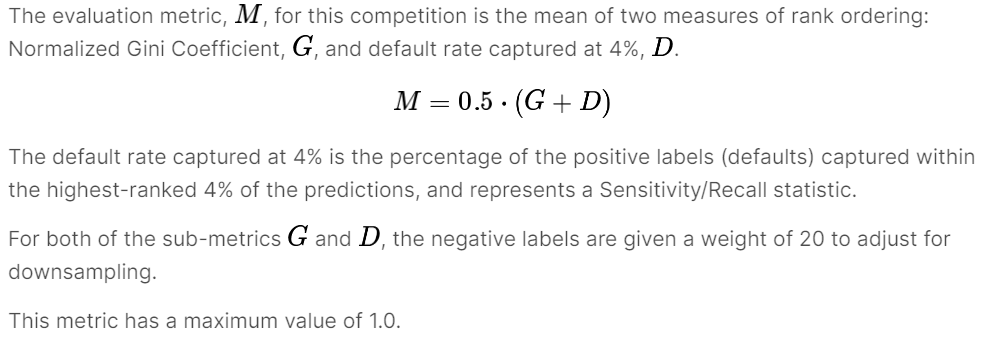

In [2]:
rf = RandomForestClassifier(
    n_estimators=500,
    min_samples_split=15,
    class_weight={0:20,1:1},
    oob_score=True,
    n_jobs=-1,
    verbose=1,
    warm_start=True
)

In [3]:
#Data loading and formatting

X = pd.concat([pd.read_pickle(f"feat_split_{i}.pkl") for i in range(1,9)])
y = pd.read_csv("train_labels.csv.zip")
y.set_index("customer_ID", inplace=True)
y = y.reindex(X.index)
y = y.iloc[:,0]

In [5]:
#Creating train and test samples

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1)

In [6]:
#fitting RandomForestClassifier

rf.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed: 21.7min
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed: 51.7min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed: 59.7min finished


RandomForestClassifier(class_weight={0: 20, 1: 1}, min_samples_split=15,
                       n_estimators=500, n_jobs=-1, oob_score=True, verbose=1,
                       warm_start=True)

In [25]:
#quality metrics on test data (from the train sample)

y_pred = rf.predict(X_test)
y_pred_proba = rf.predict_proba(X_test)[:,rf.classes_[rf.classes_ == 1][0]]
scores = pd.DataFrame(
        {"scores" : [rf.oob_score_, rf.score(X_test, y_test), roc_auc_score(y_test, y_pred_proba), f1_score(y_test, y_pred)]},
        index = ["oob_score", "accuracy", "roc_auc", "f1_score"]
)


[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    1.0s
[Parallel(n_jobs=12)]: Done 426 tasks      | elapsed:    2.7s
[Parallel(n_jobs=12)]: Done 500 out of 500 | elapsed:    3.2s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    1.1s
[Parallel(n_jobs=12)]: Done 426 tasks      | elapsed:    3.0s
[Parallel(n_jobs=12)]: Done 500 out of 500 | elapsed:    3.6s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    1.2s
[Parallel(n_jobs=12)]: Done 426 tasks      | elapsed:    3.0s
[Parallel(n_jobs=12)]: Done 500 out of 500 | elapsed: 

In [26]:
scores

,scores
oob_score,0.861416
accuracy,0.861816
roc_auc,0.935485
f1_score,0.780542


Looks quite good 
 

Attempt to implement amex_score

In [11]:
from metric import amex_metric #local module

In [9]:
# reformatting data to fit submission requirements and calculation of amex_metric

def calc_amex_metric(clf, y_test=y_test, X_test=X_test):
    y_true = pd.DataFrame({"customer_ID" : y_test.index, "target" : y_test})
    pred = clf.predict_proba(X_test)[:,clf.classes_[clf.classes_ == 1][0]]
    y_pred = pd.DataFrame({"customer_ID" : y_test.index, "prediction" : pred})
    score = amex_metric(y_true, y_pred)
    return score

In [27]:
calc_amex_metric(rf)

[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    1.1s
[Parallel(n_jobs=12)]: Done 426 tasks      | elapsed:    2.8s
[Parallel(n_jobs=12)]: Done 500 out of 500 | elapsed:    3.2s finished


-0.03954740942228246

What the... riddle? Where is bug in my code? It can't be negative, after all. Even if the model is very bad...

In [7]:
#Data export

with open("RandomForest_model.pkl", 'wb') as file: 
     pickle.dump(rf, file)